In [28]:
%load_ext autoreload
%autoreload 2
import splitwavepy as sw
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# easy problem: predict source polarisation



lstm_out = 20
batch_size = 32

model = Sequential()
# model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2, activation='linear'))
model.compile(loss = 'mean_squared_error', optimizer='adam')
print(model.summary())

In [ ]:
# code from: https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
# from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
# from keras.models import Model

# #this base model is one branch of the main model
# #it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
# def get_base_model(input_len, fsize):
#     #the input is a time series of length n and width 19
#     input_seq = Input(shape=(input_len, 19))
#     #choose the number of convolution filters
#     nb_filters = 9
#     #1-D convolution and global max-pooling
#     convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
#     processed = GlobalMaxPooling1D()(convolved)
#     #dense layer with dropout regularization
#     compressed = Dense(50, activation="tanh")(processed)
#     compressed = Dropout(0.3)(compressed)
#     model = Model(inputs=input_seq, outputs=compressed)
#     return model

# #this is the main model
# #it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
# def main_model(inputs_lens = [512, 1024, 3480], fsizes = [8,16,24]):
#     #the inputs to the branches are the original time series, and its down-sampled versions
#     input_smallseq = Input(shape=(inputs_lens[0], 19))
#     input_medseq = Input(shape=(inputs_lens[1] , 19))
#     input_origseq = Input(shape=(inputs_lens[2], 19))
#     #the more down-sampled the time series, the shorter the corresponding filter
#     base_net_small = get_base_model(inputs_lens[0], fsizes[0])
#     base_net_med = get_base_model(inputs_lens[1], fsizes[1])
#     base_net_original = get_base_model(inputs_lens[2], fsizes[2])
#     embedding_small = base_net_small(input_smallseq)
#     embedding_med = base_net_med(input_medseq)
#     embedding_original = base_net_original(input_origseq)
#     #concatenate all the outputs
#     merged = Concatenate()([embedding_small, embedding_med, embedding_original])
#     out = Dense(1, activation='sigmoid')(merged)
#     model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
#     return model

In [126]:


#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_len, fsize):
    #the input is a time series of length n and width 19
    input_seq = Input(shape=(input_len, 2))
    #choose the number of convolution filters
    nb_filters = 10
    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [124, 250, 501], fsizes = [2, 4, 8]):
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape=(inputs_lens[0], 2))
    input_medseq = Input(shape=(inputs_lens[1] , 2))
    input_origseq = Input(shape=(inputs_lens[2], 2))
    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    #concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    merged = Dense(10, activation='relu')(merged)
    out = Dense(2, activation='linear')(merged)
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model

In [249]:
# def __data_generation(self, list_IDs_temp):
#     'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#     # Initialization
#     X = np.empty((self.batch_size, *self.dim, self.n_channels))
#     y = np.empty((self.batch_size), dtype=int)

#     # Generate data
#     for i, ID in enumerate(list_IDs_temp):
#       # Store sample
#       X[i,] = np.load('data/' + ID + '.npy')

#       # Store class
#       y[i] = self.labels[ID]

#     return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

def downsample(t, pts=3):
    """drops every other sample in time series t."""
    # anti-alias using 3 pt boxcar
    boxcar = np.ones(pts)/pts
    aa = np.convolve(t, boxcar, 'valid')
    return aa[0::2]

def ds2(X):
    """downsample 2 channels at once."""
    x = downsample(X[:,0])
    y = downsample(X[:,1])
    return np.vstack((x, y)).T

def datagen(fast, lag, **kwargs):
    """generate a synthetic and some labels."""
    data = sw.Data(split=(fast, lag), **kwargs)
    data.set_window(25, 75)
    x = data.chop().data
    return x.T

    

# def genbatch(batchsize=30, **kwargs):
#     """generate a batch of training data."""
#     X0 = np.empty((batchsize, 2, 501))
#     X1 = np.empty((batchsize, 2, 250))
#     X2 = np.empty((batchsize, 2, 124))
#     y = np.empty((batchsize, 2))
#     for i in range(batchsize):
#         # generate a random splitting parameter
#         # use uniform distribution to pick a fast direction:
#         fast = np.random.uniform(low=0, high=180, size=1)[0]
#         # use exponential distribution to pick a lag (so you get less big values):
#         lag = np.random.exponential(scale=1, size=1)[0]
#         # label
#         y[i,:] = np.array([fast, lag]).T
#         # data
#         X0[i,] = datagen(fast, lag, **kwargs)
#         X1[i,] = ds2(X0[i,])
#         X2[i,] = ds2(X1[i,])
#     return X0, X1, X2, y

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, n=3000, batch_size=32):
        'Initialization'
        self.n = n
        self.batch_size = batch_size
        
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)
        pass

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.n // self.batch_size

    def __getitem__(self, index, **kwargs):
        'Generate one batch of data'
        # Generate data
        return self.__data_generation(**kwargs)

    def __data_generation(self, **kwargs):
        """generate a batch of training data."""
#         X0 = np.empty((self.batch_size, 2, 501))
#         X1 = np.empty((self.batch_size, 2, 250))
#         X2 = np.empty((self.batch_size, 2, 124))
        X0 = np.empty((self.batch_size, 501, 2))
        X1 = np.empty((self.batch_size, 250, 2))
        X2 = np.empty((self.batch_size, 124, 2))
        y = np.empty((self.batch_size, 2))
        fasts = np.random.uniform(low=0, high=180, size=self.batch_size)
        lags = np.random.exponential(scale=1.5, size=self.batch_size)
        noises = np.random.exponential(scale=0.02, size=self.batch_size)
        for i in range(self.batch_size):
            # generate a random splitting parameter
            # use uniform distribution to pick a fast direction:
            fast = fasts[i]
            lag = lags[i]
            noise = noises[i]
            # label
            ang = math.radians(2*fast) # double angle to deal with 180 deg ambiguity
            y[i,0] = lag * math.cos(ang)
            y[i,1] = lag * math.sin(ang)
#             y[i,:] = np.array([fast, lag]).T
            # data
            X0[i,:,:] = datagen(fast, lag, noise=noise, **kwargs)
            X1[i,:,:] = ds2(X0[i,:,:])
            X2[i,:,:] = ds2(X1[i,:,:])
        return [X2, X1, X0], y

    
#     def generator_two_img(X1, X2, y, batch_size):
#         genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
#         genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
#         while True:
#             X1i = genX1.next()
#             X2i = genX2.next()
#             yield [X1i[0], X2i[0]], X1i[1]
            
#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    

In [255]:
# m = main_model()
# m.compile(loss='mean_squared_error', optimizer='adam')

# Train model on dataset
m.fit_generator(generator=DataGenerator(n=3000, batch_size=30), epochs=300)


Epoch 1/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6380
Epoch 2/300
100/100 [==============================] - 15s 146ms/step - loss: 0.7370
Epoch 3/300
100/100 [==============================] - 15s 147ms/step - loss: 0.7198
Epoch 4/300
100/100 [==============================] - 15s 147ms/step - loss: 0.7162
Epoch 5/300
100/100 [==============================] - 15s 147ms/step - loss: 0.6784
Epoch 6/300
100/100 [==============================] - 14s 145ms/step - loss: 0.8893
Epoch 7/300
100/100 [==============================] - 15s 148ms/step - loss: 0.9229
Epoch 8/300
100/100 [==============================] - 14s 144ms/step - loss: 0.8812
Epoch 9/300
100/100 [==============================] - 15s 147ms/step - loss: 0.6806
Epoch 10/300
100/100 [==============================] - 15s 147ms/step - loss: 0.6910
Epoch 11/300
100/100 [==============================] - 15s 147ms/step - loss: 0.7756
Epoch 12/300
100/100 [==============================] - 15s 147

100/100 [==============================] - 14s 144ms/step - loss: 0.8194
Epoch 97/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6202
Epoch 98/300
100/100 [==============================] - 14s 145ms/step - loss: 0.6678
Epoch 99/300
100/100 [==============================] - 15s 145ms/step - loss: 0.8934
Epoch 100/300
100/100 [==============================] - 14s 144ms/step - loss: 0.6629
Epoch 101/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6983
Epoch 102/300
100/100 [==============================] - 15s 150ms/step - loss: 0.8030
Epoch 103/300
100/100 [==============================] - 15s 145ms/step - loss: 0.7010
Epoch 104/300
100/100 [==============================] - 15s 147ms/step - loss: 0.9343
Epoch 105/300
100/100 [==============================] - 15s 146ms/step - loss: 0.7230
Epoch 106/300
100/100 [==============================] - 15s 147ms/step - loss: 0.7815
Epoch 107/300
100/100 [==============================] - 15s

100/100 [==============================] - 15s 154ms/step - loss: 0.7038
Epoch 191/300
100/100 [==============================] - 15s 151ms/step - loss: 0.9155
Epoch 192/300
100/100 [==============================] - 15s 146ms/step - loss: 0.5749
Epoch 193/300
100/100 [==============================] - 15s 149ms/step - loss: 0.6919
Epoch 194/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6946
Epoch 195/300
100/100 [==============================] - 15s 147ms/step - loss: 0.7118
Epoch 196/300
100/100 [==============================] - 15s 150ms/step - loss: 0.6775
Epoch 197/300
100/100 [==============================] - 15s 150ms/step - loss: 0.6777
Epoch 198/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6325
Epoch 199/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6405
Epoch 200/300
100/100 [==============================] - 15s 149ms/step - loss: 0.7718
Epoch 201/300
100/100 [==============================] - 

100/100 [==============================] - 15s 146ms/step - loss: 0.7184
Epoch 285/300
100/100 [==============================] - 15s 146ms/step - loss: 0.7703
Epoch 286/300
100/100 [==============================] - 15s 148ms/step - loss: 0.7519
Epoch 287/300
100/100 [==============================] - 15s 147ms/step - loss: 0.6596
Epoch 288/300
100/100 [==============================] - 15s 146ms/step - loss: 0.7274
Epoch 289/300
100/100 [==============================] - 15s 147ms/step - loss: 0.8194
Epoch 290/300
100/100 [==============================] - 15s 146ms/step - loss: 0.7914
Epoch 291/300
100/100 [==============================] - 15s 149ms/step - loss: 0.7153
Epoch 292/300
100/100 [==============================] - 15s 147ms/step - loss: 0.8349
Epoch 293/300
100/100 [==============================] - 15s 148ms/step - loss: 0.7141
Epoch 294/300
100/100 [==============================] - 15s 146ms/step - loss: 0.6348
Epoch 295/300
100/100 [==============================] - 

In [261]:
fast, lag = -35, 1.3
X0 = np.empty((1, 501, 2))
X1 = np.empty((1, 250, 2))
X2 = np.empty((1, 124, 2))
X0[0,:,:] = datagen(fast, lag, noise=0.01)
X1[0,:,:] = ds2(X0[0,:,:])
X2[0,:,:] = ds2(X1[0,:,:])
pred = m.predict([X2, X1, X0])[0]
pfast = .5*math.degrees(math.atan2(pred[1], pred[0]))
plag = math.sqrt(pred[0]**2 + pred[1]**2)
print(pfast, plag)


-44.52246211769595 1.2131721792041736


In [262]:
m.save('brain2')


## PickBrain

RNN to identify arrival trained on real picked data and synthetics.

## SplitBrain

CNN to find splitting parameters trained on synthetics.

Synthetic Generation:

- noise
- wavelet
- intefering arrivals
- 1 layer parameters
- 2 layer parameters




In [266]:
brain1 = keras.models.load_model('brain1')
brain2 = keras.models.load_model('brain2')
# keras.models.
# pwd

In [188]:
def validate_model(model, fast, lag, **kwargs):
#     fast, lag = -35, 3
    X0 = np.empty((1, 501, 2))
    X1 = np.empty((1, 250, 2))
    X2 = np.empty((1, 124, 2))
    X0[0,:,:] = datagen(fast, lag, noise=0.01)
    X1[0,:,:] = ds2(X0[0,:,:])
    X2[0,:,:] = ds2(X1[0,:,:])
    pred = model.predict([X2, X1, X0])[0]
    pfast = .5*math.degrees(math.atan2(pred[1], pred[0]))
    plag = math.sqrt(pred[0]**2 + pred[1]**2)
    print(pfast, plag)
    
validate_model(brain1, 30, 1.5)

33.50668094570867 1.6058316872059069


In [269]:
validate_model(brain2, 30, 1.5, noise=0.01)

31.265300275752303 1.8161592724054751


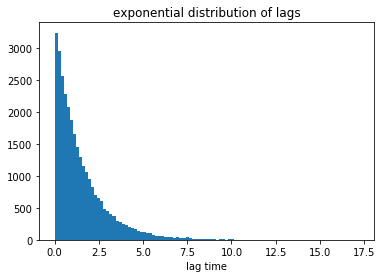

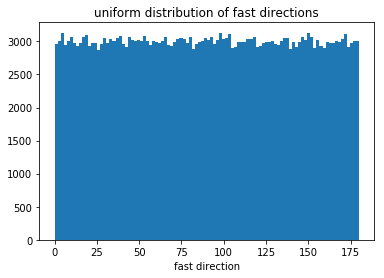

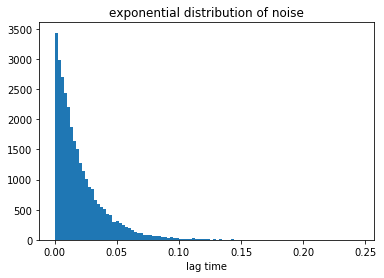

In [248]:
plt.hist(np.random.exponential(scale=1.5, size=30000), bins=100)
plt.title('exponential distribution of lags')
plt.xlabel('lag time')
plt.show()

plt.hist(np.random.uniform(low=0, high=180, size=300000), bins=100)
plt.title('uniform distribution of fast directions')
plt.xlabel('fast direction')
plt.show()

plt.hist(np.random.exponential(scale=0.02, size=30000), bins=100)
plt.title('exponential distribution of noise')
plt.xlabel('lag time')
plt.show()

In [ ]:
3000/32

In [ ]:
fast, lag = 30, 1.2
split = (fast, lag)
noise = 0.01
d = sw.Data(split=split, noise=noise)
m = d.Meas()
m.plot()

In [ ]:
d = sw.Data(split=(30,4))
d.set_window(25,75)
d.plot()
d.chop().shape

In [ ]:
3000//32

In [ ]:
m = data.Meas()
plt.contourf(*m._grid, m.bslam2pdf())
plt.show()


In [ ]:
# fast, lag = 30, 1.2
# split = (fast, lag)
# noise = 0.02
# d = sw.Data(split=split, noise=noise)
m = d.Meas()

plt.contourf(*m._grid, m.bszrhopdf
plt.title('rho bootstrap')
plt.show()

# plt.title('rho f-test')
# plt.contourf(*m._grid, m.fzrhopdf())
# plt.show()

# plt.contourf(*m._grid, m.bslam2pdf())
# plt.title('lam2 bootstrap')
# plt.show()

# plt.contourf(*m._grid, m.flam2pdf())
# plt.title('lam2 f-test')
# plt.show()

In [ ]:
%timeit m.flam2pdf()

In [ ]:
%timeit m.bszrhopdf

In [ ]:
pol = unsplit._estimate_pol()
unsplit.rotateto(pol)._chopxy()

In [ ]:
fast, lag = 30, 1.2
split = (fast, lag)
noise = 0.05
data = sw.Data(split=split, noise=noise)
m = data.Meas()
m.plot()

In [ ]:
vals = m.lam2
fast, lag = m._fast_lag_minloc(vals)
print(fast, lag)

In [ ]:
m.silver_chan()
m.cross_corr()

In [ ]:
m.silver_chan()

In [ ]:
vals = m.zrho
fast, lag = m._fast_lag_maxloc(vals)
ndf = m.ndf(fast, lag)
ftestalpha = m.ftest_max(vals, ndf, 0.05)


In [ ]:
ftestalpha.max()

In [ ]:
m.report()

In [ ]:
m.splitting_intensity()

In [ ]:
m.plot()

In [ ]:
m.srcpoldata().chop()

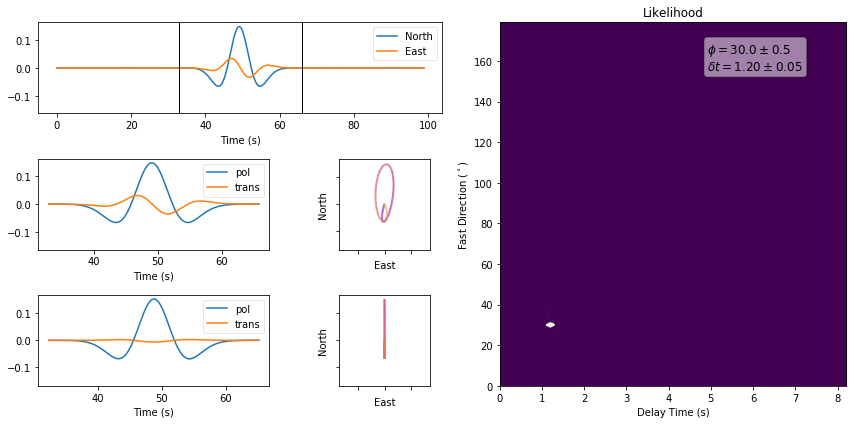

In [273]:
sw.synth(split=(30,1.2)).plot()

In [ ]:
sw.funcs.